## Bayesian Optimisation Verification

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy import interpolate
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy import stats
from scipy.stats import norm
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import cdist
from scipy.optimize import fsolve
import math

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
# Setup data for training and evaluation
X_ = np.linspace(0,5000, 5000)
# import timestamp from data sheet (time:0~5000s) 
address = 'data/degradation.xlsx'
df_time = X_
# import data sheet at 85 C (time:0~5000s) 
df = pd.read_excel(address,sheet_name = 'normal data',usecols = [3],names = None,nrows = 5000)
df_85 = df.values.tolist() 
df = pd.read_excel(address,sheet_name = 'smooth data',usecols = [3],names = None,nrows = 5000)
df_85s = df.values.tolist()
# Format date into numpy array format
y_normal = np.array(df_85).T 
y_normal = y_normal.reshape((5000))
x_normal = X_
x_7_5000 = np.array([0,99,999,1999,2999,3999,4999])

In [3]:
# Plot function to show confidence bounds 
def plot (x_normal ,y_normal, X,X_,y_mean,Y,y_cov):
    #plot function
    plt.figure()
    plt.plot(X_, y_mean, 'k', lw=1, zorder=4)
    plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),y_mean + np.sqrt(np.diag(y_cov)),alpha=0.5, color='k')
    # plt.scatter(X[:, 0], Y, c='r', s=1, zorder=3)
    plt.plot(x_normal, y_normal, 'c', lw=1, zorder=2)
    plt.tick_params(axis='y', colors = 'white')
    plt.tick_params(axis='x', colors = 'white')
    plt.ylabel('Lifetime',color = 'white')
    plt.xlabel('Time',color = 'white')
    plt.title('Original cb plot',color = 'white')
    plt.xlim(0,4900)
    plt.ylim(0.7,0.8)
    plt.tight_layout()
    plt.show()

In [4]:
# Plot function to show ucb minimum bound
def ucbplot(X,Y,X_, y_mean,ucb_y_min):
    plt.figure()
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean, ucb_y_min,alpha=0.5, color='k')
    plt.scatter(X[:, 0], Y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.scatter(np.argmin(ucb_y_min),min(ucb_y_min),c='g', s=50)
    plt.tick_params(axis='y', colors = 'white')
    plt.tick_params(axis='x', colors = 'white')
    plt.ylabel('Lifetime',color = 'white')
    plt.xlabel('Time',color = 'white')
    plt.title('UCB lower bound plot',color = 'white')
    plt.tight_layout()
    plt.show()

In [9]:
# Aquisition equations 
def ucb(X , gp, dim, delta):
	"""
	Calculates the GP-UCB acquisition function values
	Inputs: gp: The Gaussian process, also contains all data
	x:The point at which to evaluate the acquisition function 
	Output: acq_value: The value of the aquisition function at point x
	"""
	mean, var = gp.predict(X[:, np.newaxis], return_cov=True)
	# mean = np.atleast_2d(mean).T
	# var = np.atleast_2d(var).T  
	beta = 2*np.log(np.power(5000,2.1)*np.square(np.pi)/(3*delta))
	return mean - np.sqrt(beta) * np.sqrt(np.diag(var))

def ucb_no_beta(X , gp, dim, delta):
	"""
	Calculates the GP-UCB acquisition function values
	Inputs: gp: The Gaussian process, also contains all data
	x:The point at which to evaluate the acquisition function 
	Output: acq_value: The value of the aquisition function at point x
	"""
	mean, var = gp.predict(X[:, np.newaxis], return_cov=True)
	# mean = np.atleast_2d(mean).T
	# var = np.atleast_2d(var).T  
	beta = 2*np.log(np.power(5000,2.1)*np.square(np.pi)/(3*delta))
	return mean - np.sqrt(np.diag(var))

def ei(X, gp, y_max):
	"""
	Calculates the EI acquisition function values
	Inputs: gp: The Gaussian process, also contains all data
	y_max: The maxima of the found y values
	x:The point at which to evaluate the acquisition function 
	Output: acq_value: The value of the aquisition function at point x
	"""
	y_max = np.asscalar(y_max)
	mean, var = gp.predict(X[:, np.newaxis], return_cov=True)
	var2 = np.maximum(var, 1e-8 + 0 * var)
	z = (mean - y_max)/np.sqrt(var2)        
	out=(mean - y_max) * norm.cdf(z) + np.sqrt(var2) * norm.pdf(z)
	out[var2<1e-8]=0
	return out

def rucb_balance(X, gp, dim, delta):
	"""
	Calculates the RGP-UCB acquisition function values with a theta
	favoring a balance of exploration and expoitation.
	Inputs: gp: The Gaussian process, also contains all data
			x:The point at which to evaluate the acquisition function 
	Output: acq_value: The value of the aquisition function at point x
	"""

	mean, var = gp.predict(X[:, np.newaxis], return_cov=True)
	mean = np.atleast_2d(mean).T
	var = np.atleast_2d(var).T
	#np.random.seed(5000*iterations_num)
	theta=1
	k=np.log((np.square(5000)+1)/np.sqrt(2)*math.pi)/np.log(1+theta/2)
	distbeta=np.random.gamma(scale=k,shape=theta,size=1)         
	#print('k={}, theta={}'.format(k,theta))
	return mean - np.sqrt(distbeta)* np.sqrt(np.diag(var))

In [6]:
# Function to find the length scale bound max automatically
def find_lsb_max (x_normal ,y_normal,X,X_,Y):
    # Length scale list from 10^-1 to 10^4 in 0.1 increments 
    ls_power = np.linspace(-1,4,20)
    ls_list = np.power(10,ls_power)
    length_scale_bounds_MIN = 1e-6

    for length_scale_bounds_MAX in ls_list:
        kernel = 1.0 * RBF(length_scale=20,length_scale_bounds=(length_scale_bounds_MIN, length_scale_bounds_MAX)) + WhiteKernel(noise_level=0.0001)
        gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, Y)
        y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
        # print ('Average absolute error:',
        # np.format_float_scientific(np.mean(np.absolute(y_normal-y_mean)),precision=5))
        average_percentage_error = np.mean(np.absolute((y_normal-y_mean)/y_normal*100))
        # print('Length scale bound max =',length_scale_bounds_MAX,' Percentage error =',average_percentage_error)

        if average_percentage_error < 0.2:
            break
    # print('Length scale bound max =',length_scale_bounds_MAX)
    # print ('Average percentage error:',
    # np.format_float_positional(np.mean(np.absolute((y_normal-y_mean)/y_normal*100)),precision=4),'%')
    return int(length_scale_bounds_MAX)

# find_lsb_max (x_normal ,y_normal,X,X_,Y)


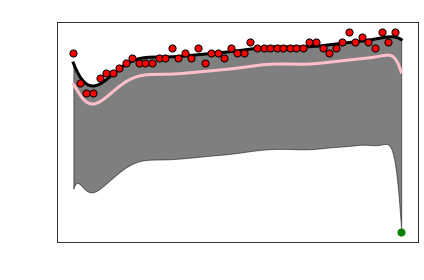

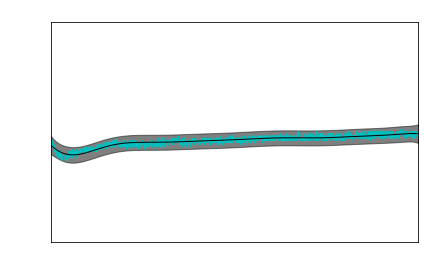

In [11]:
# Find lsb max demo 
NUM_OF_DATA_POINTS = 50
x_loop = np.arange(0,5000,int(5000/NUM_OF_DATA_POINTS))
X = x_normal[x_loop].reshape(x_loop.size)
Y = y_normal[x_loop]
X = X.reshape(x_loop.size,1)
X_ = np.linspace(0,5000, 5000)
# Kernel setting
length_scale_bounds_MAX =1000
#  find_lsb_max (x_normal ,y_normal,X,X_,Y)
length_scale_bounds_MIN = 10e-6
kernel = 1.0 * RBF(length_scale=20,length_scale_bounds=(length_scale_bounds_MIN, length_scale_bounds_MAX)) + WhiteKernel(noise_level=0.0001)
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, Y)

# Find the prediction by gp
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
ucb_y_min = ucb(X_, gp, 0.1, 5)
ucb_nb_y = ucb_no_beta(X_, gp, 0.1, 5)
# ucb_y_min = ucb_y_min[-1]
# ucb_nb_y = ucb_nb_y[-1]
plt.figure()
plt.plot(X_, y_mean, 'k', lw=3, zorder=8)
plt.fill_between(X_, y_mean, ucb_y_min,alpha=0.5, color='k')
plt.plot(X_, ucb_nb_y, 'pink', lw=3, zorder=9)

plt.scatter(X[:, 0], Y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.scatter(np.argmin(ucb_y_min),min(ucb_y_min),c='g', s=50)
plt.tick_params(axis='y', colors = 'white')
plt.tick_params(axis='x', colors = 'white')
plt.ylabel('Lifetime',color = 'white')
plt.xlabel('Time',color = 'white')
plt.title('UCB lower bound plot',color = 'white')
plt.tight_layout()
plt.show()

plot(x_normal ,y_normal, X,X_,y_mean,Y,y_cov)


Number of data points used: 20
Length scale bound max = 10000
Average absolute error: 6.00136e-01
Average percentage error: 80.4438 %


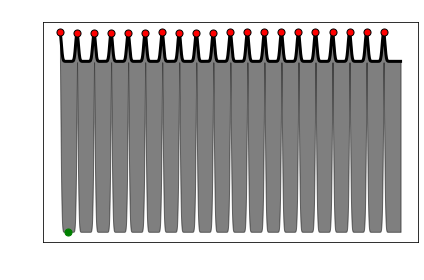

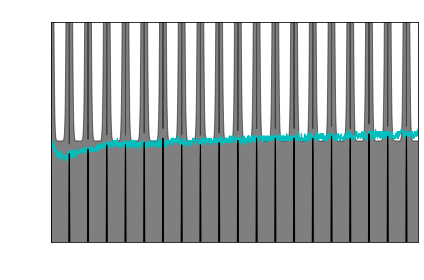

Number of data points used: 31
Length scale bound max = 10000
Average absolute error: 5.19087e-01
Average percentage error: 69.5819 %


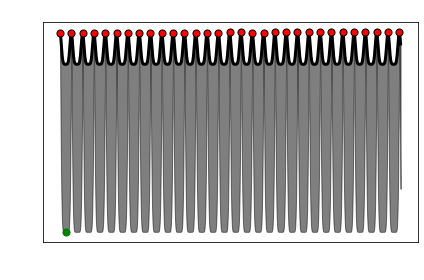

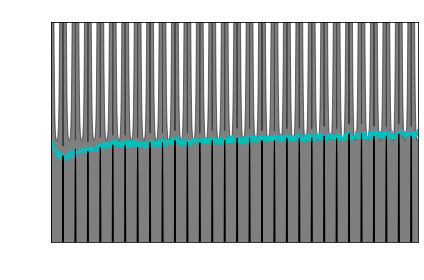

Number of data points used: 40
Length scale bound max = 10000
Average absolute error: 4.50569e-01
Average percentage error: 60.3943 %


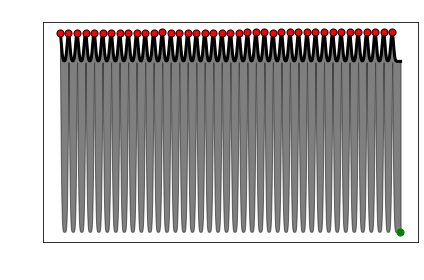

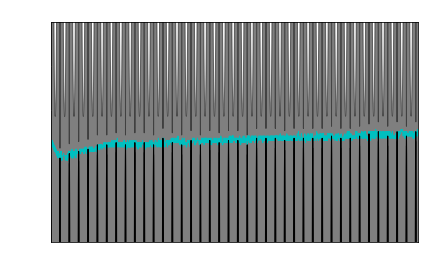

Number of data points used: 50
Length scale bound max = 263
Average absolute error: 8.42555e-04
Average percentage error: 0.1130 %


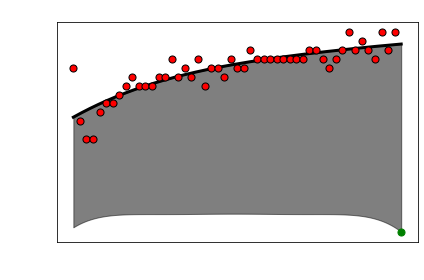

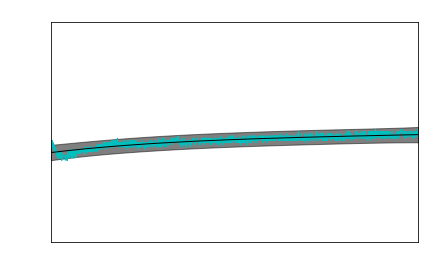

Number of data points used: 61
Length scale bound max = 143
Average absolute error: 8.10789e-04
Average percentage error: 0.1087 %


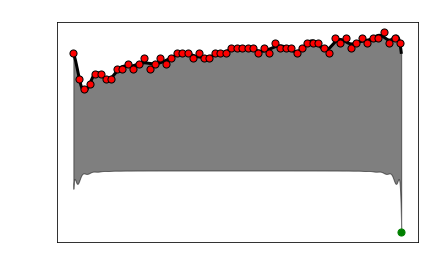

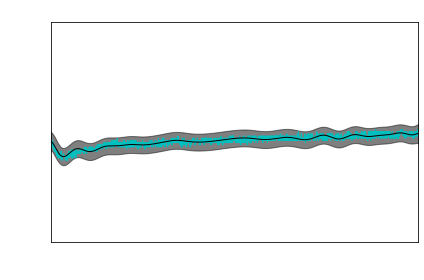

Number of data points used: 81
Length scale bound max = 143
Average absolute error: 9.76439e-04
Average percentage error: 0.1309 %


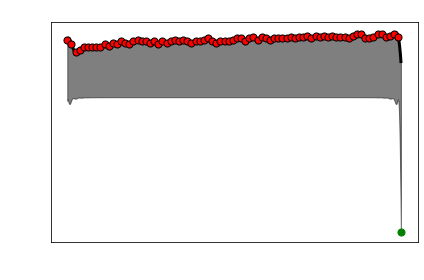

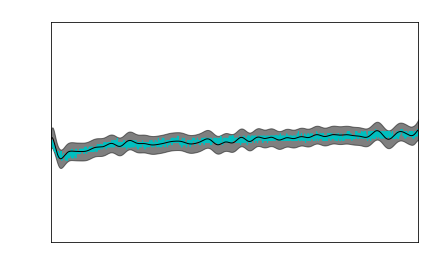

Number of data points used: 100
Length scale bound max = 78
Average absolute error: 9.03207e-04
Average percentage error: 0.1210 %


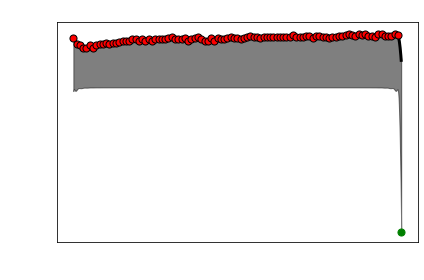

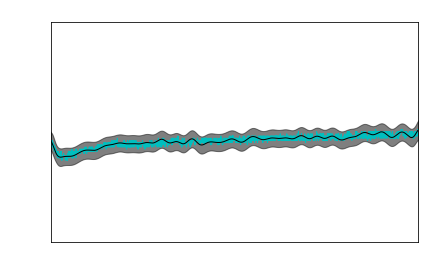

Number of data points used: 122
Length scale bound max = 78
Average absolute error: 9.12173e-04
Average percentage error: 0.1222 %


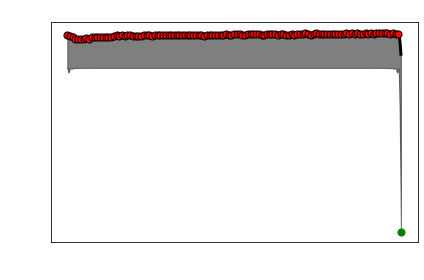

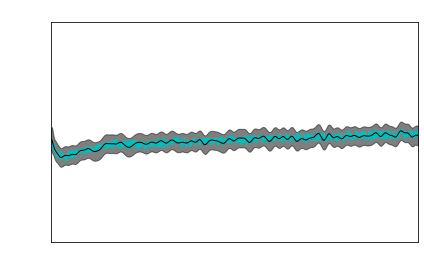

Number of data points used: 152
Length scale bound max = 42
Average absolute error: 8.13376e-04
Average percentage error: 0.1090 %


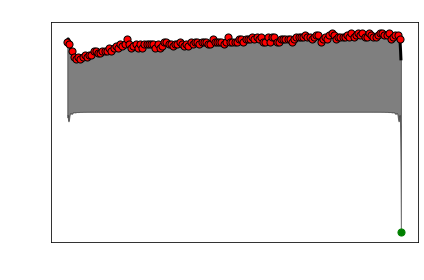

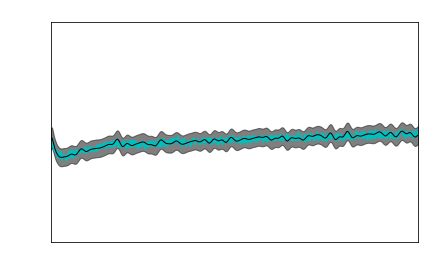

Number of data points used: 200
Length scale bound max = 42
Average absolute error: 9.79253e-04
Average percentage error: 0.1312 %


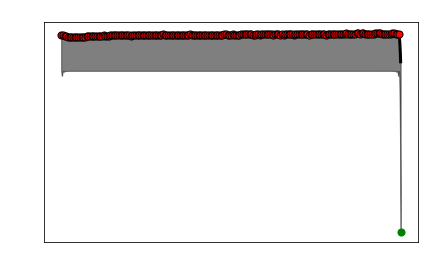

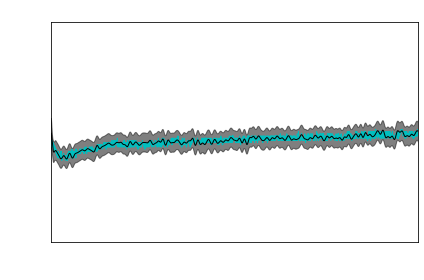

Number of data points used: 313
Length scale bound max = 12
Average absolute error: 7.48844e-04
Average percentage error: 0.1004 %


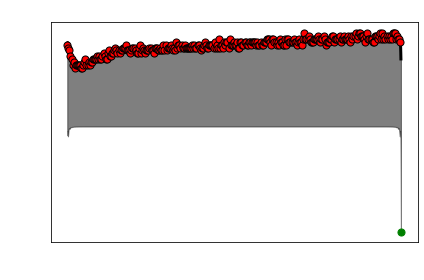

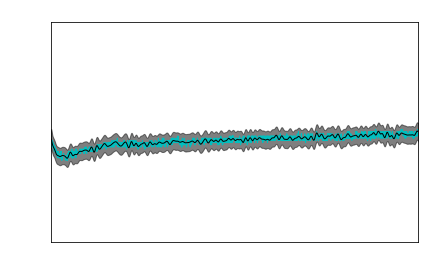

Number of data points used: 500
Length scale bound max = 6
Average absolute error: 9.15053e-04
Average percentage error: 0.1226 %


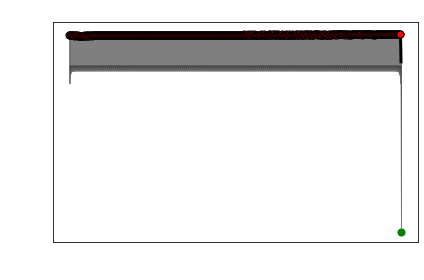

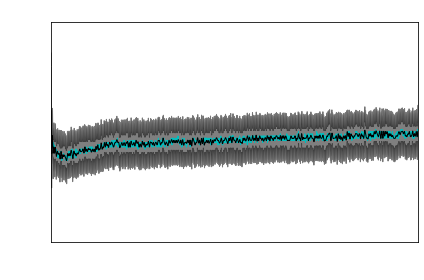

In [ ]:
# Ploting ucb value from ei aquisition equation 
# with different amound of data
# with lsb max
# Kernel setting
length_scale_bounds_MAX = 1000
length_scale_bounds_MIN = 1e-4

for NUM_OF_DATA_POINTS in (20,30,40,50,60,80,100,120,150,200,300,500):
    x_loop = np.arange(0,5000,int(5000/NUM_OF_DATA_POINTS))
    X = x_normal[x_loop].reshape(x_loop.size)
    Y = y_normal[x_loop]
    X = X.reshape(x_loop.size,1)
    
    kernel = 1.0 * RBF(length_scale=20,length_scale_bounds=(length_scale_bounds_MIN, length_scale_bounds_MAX)) + WhiteKernel(noise_level=0.00000001)
    gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0).fit(X, Y)
    y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)

    # Get ucb prediction
    ucb_y_min = ucb(X_, gp, 0.1, 5)
    X_min = np.argmin(acp_value[-1])
    # ucb_y_min = ucb_y_min[-1]
    # ei_value = ei(X_, gp, max(y_normal))
    # print(ei_value)
    # rucb_value = rucb_balance(X_, gp, 0.1,5)
    
    print('Number of data points used:', x_loop.size)
    length_scale_bounds_MAX = find_lsb_max(x_normal ,y_normal,X,X_,Y)
    print('Length scale bound max =',length_scale_bounds_MAX)
    print ('Average absolute error:',
    np.format_float_scientific(np.mean(np.absolute(y_normal-y_mean)),precision=5))
    print ('Average percentage error:',
    np.format_float_positional(np.mean(np.absolute((y_normal-y_mean)/y_normal*100)),precision=4),'%')
    ucbplot(X,Y,X_, y_mean,ucb_y_min)
    plot(x_normal ,y_normal, X,X_,y_mean,Y,y_cov)
